## 1 Compare Hand-coded vs. NN policy

### 1.1 Hand-coded

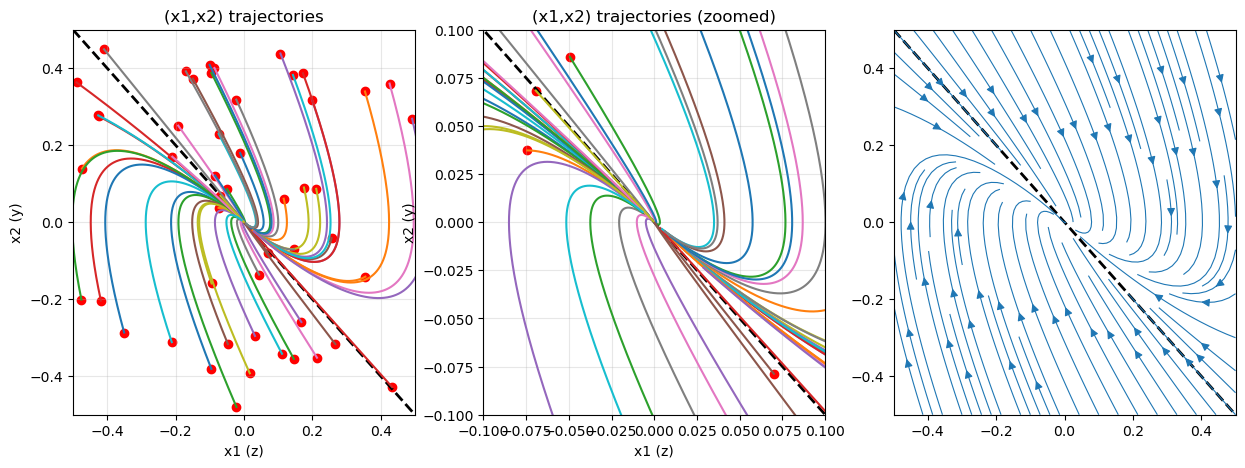

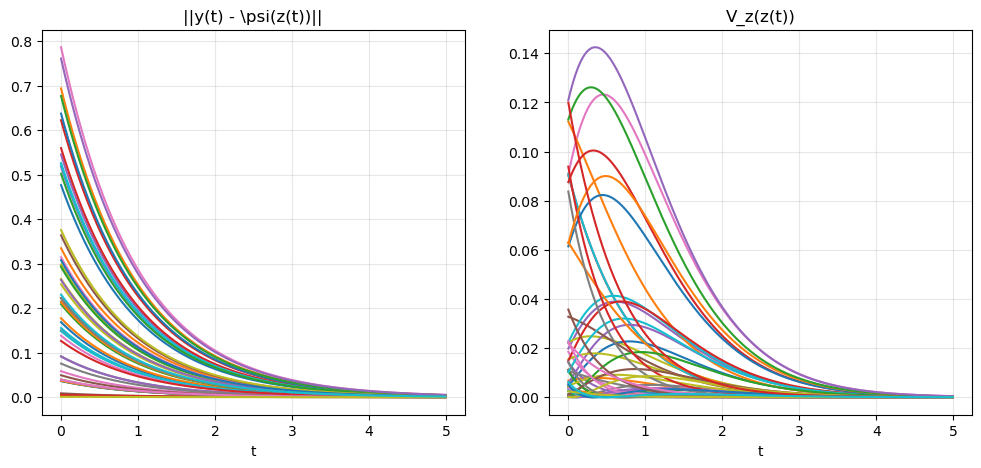

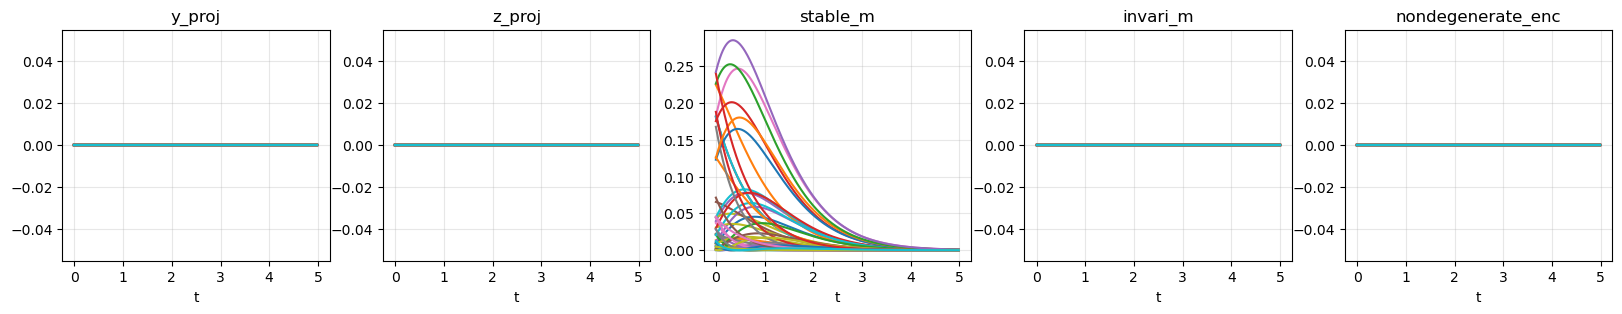

In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from einops import rearrange
from double_integrator import *
from my_train import *


box_width = 0.5

cfg_rom = CfgDIROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

rom = DoubleIntegratorROM(cfg_rom=cfg_rom)
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (50, 2), minval=-box_width, maxval=box_width)

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts,
)

rom = DoubleIntegratorROM(cfg_rom=cfg_rom)

ret = integrator.apply(x0s, rom)
aux_ret = integrator.post_apply(ret, rom)
loss_ret = integrator.compute_loss(ret, rom)

make_plots(rom, ret, aux_ret, loss_ret, box_width=box_width)

### 1.2 NN-based, hardcoded params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1,) (50, 1)


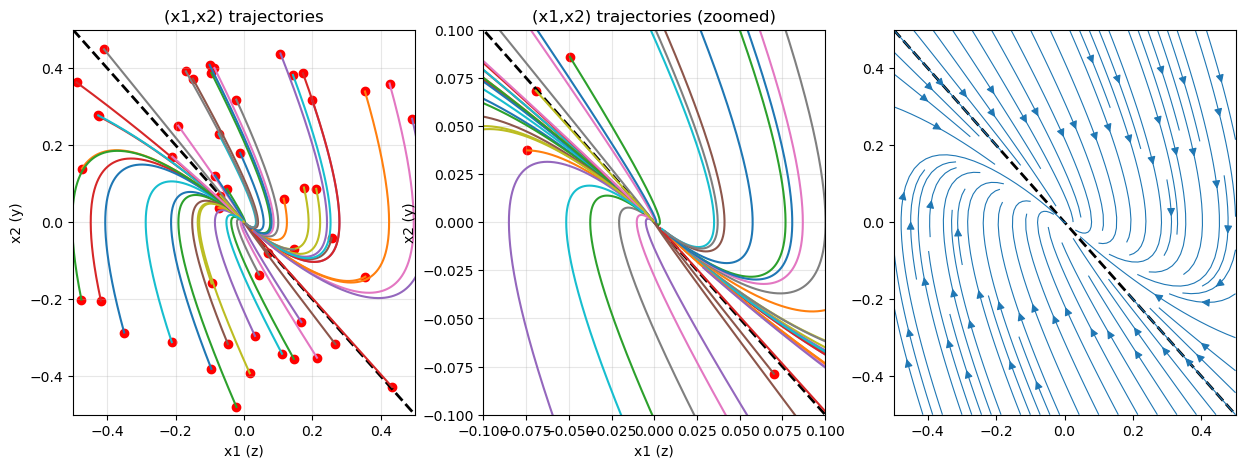

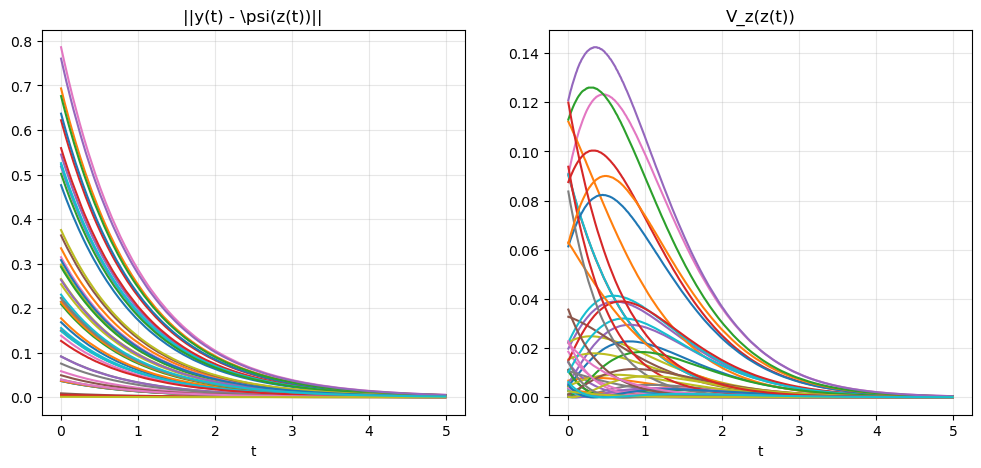

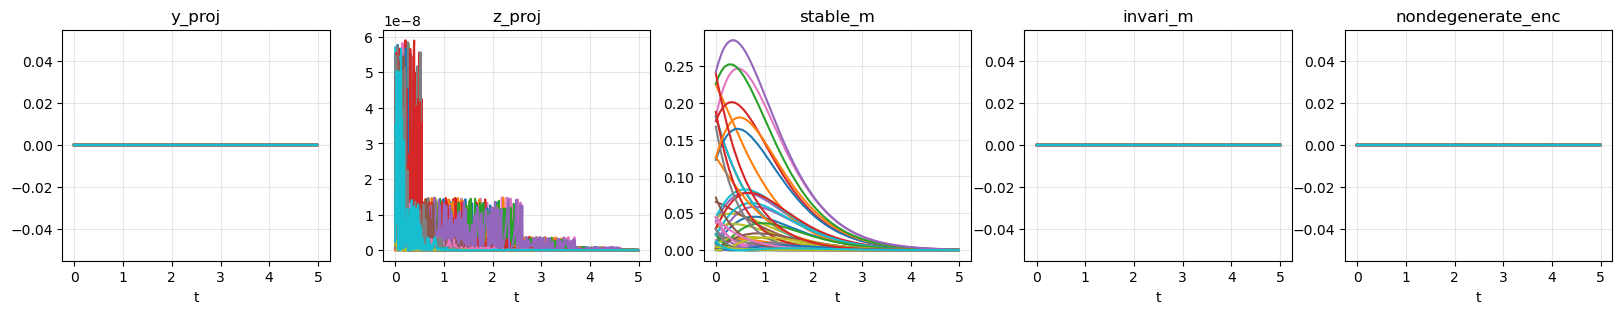

In [2]:
%load_ext autoreload
%autoreload 2


import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from double_integrator import *


box_width = 0.5

cfg_rom = CfgDIROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

params = flax.core.FrozenDict({}) # place holder for NN parameters
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (50, 2), minval=-box_width, maxval=box_width)

rom = NNDoubleIntegratorROM(cfg_rom=cfg_rom)
rom.hardcode_nn_params()

integrator = Integrator(solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()), ts=ts)

ret1 = rom.policy_v(1.0, 1.0)
ret2 = jax.vmap(rom.policy_v, in_axes=(0, 0))(
    jnp.ones((50,)),
    jnp.ones((50,))
)

print(ret1.shape, ret2.shape)

ret = integrator.apply(x0s, rom)
aux_ret = integrator.post_apply(ret, rom)
loss_ret = integrator.compute_loss(ret, rom)
make_plots(rom, ret, aux_ret, loss_ret)

    

In [3]:
rom.get_nn_params()

{'nn_encoder': {'kernel': Array([[0., 1.],
         [1., 0.]], dtype=float32),
  'bias': None},
 'nn_decoder': {'kernel': Array([[0., 1.],
         [1., 0.]], dtype=float32),
  'bias': None},
 'nn_fy': {'kernel': Array([[0.]], dtype=float32), 'bias': None},
 'nn_gy': {'kernel': Array([[0.]], dtype=float32),
  'bias': Array([1.], dtype=float32)},
 'nn_fz': {'kernel': Array([[1.],
         [0.]], dtype=float32),
  'bias': None},
 'nn_psi': {'kernel': Array([[1.]], dtype=float32), 'bias': None}}

## 2. Actually Learn NN Policy

In [1]:

%load_ext autoreload
%autoreload 2

import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from einops import rearrange
import jax.tree_util as jtu
from double_integrator import *
from my_train import *


cfg_rollout = CfgRollout()
cfg_train = CfgTrain()
cfg_data = CfgData()
cfg_rom = CfgDIROM()
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
rng = jax.random.PRNGKey(42)
  
rom = NNDoubleIntegratorROM(cfg_rom=cfg_rom)
rom.hardcode_nn_params()

params = rom.get_nn_params()
leaves, treedef = jtu.tree_flatten(params)
keys = jax.random.split(rng, len(leaves))
keys_tree = jtu.tree_unflatten(treedef, keys)

corrupted_params = jtu.tree_map(
    lambda x, k: x + jax.random.normal(k, x.shape),
    params, keys_tree
)
rom.set_nn_params(corrupted_params)

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts
)

train(rom, integrator, cfg_train, cfg_data, rng)

rom.get_nn_params()

 68%|██████▊   | 68/100 [01:46<00:50,  1.57s/it, loss=1.10e+00, lr=2.97e-03]

Training interrupted by user


{'nn_encoder': {'kernel': Array([[ 0.7309673 ,  1.5009497 ],
         [ 0.42484215, -0.278878  ]], dtype=float32),
  'bias': None},
 'nn_decoder': {'kernel': Array([[0.07592554, 0.51365733],
         [2.2903206 , 0.5196119 ]], dtype=float32),
  'bias': None},
 'nn_fy': {'kernel': Array([[0.69733655]], dtype=float32), 'bias': None},
 'nn_gy': {'kernel': Array([[-0.04747605]], dtype=float32),
  'bias': Array([1.3088974], dtype=float32)},
 'nn_fz': {'kernel': Array([[ 0.98540986],
         [-1.1702099 ]], dtype=float32),
  'bias': None},
 'nn_psi': {'kernel': Array([[0.99567384]], dtype=float32), 'bias': None}}

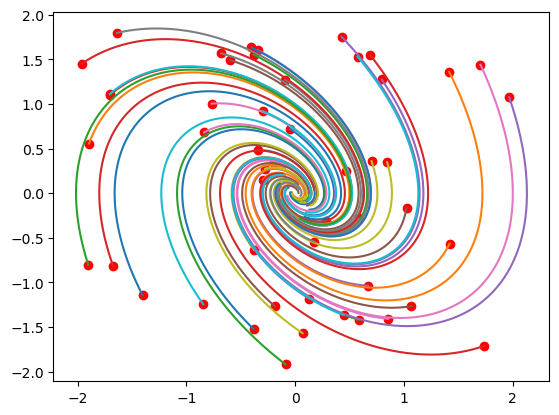

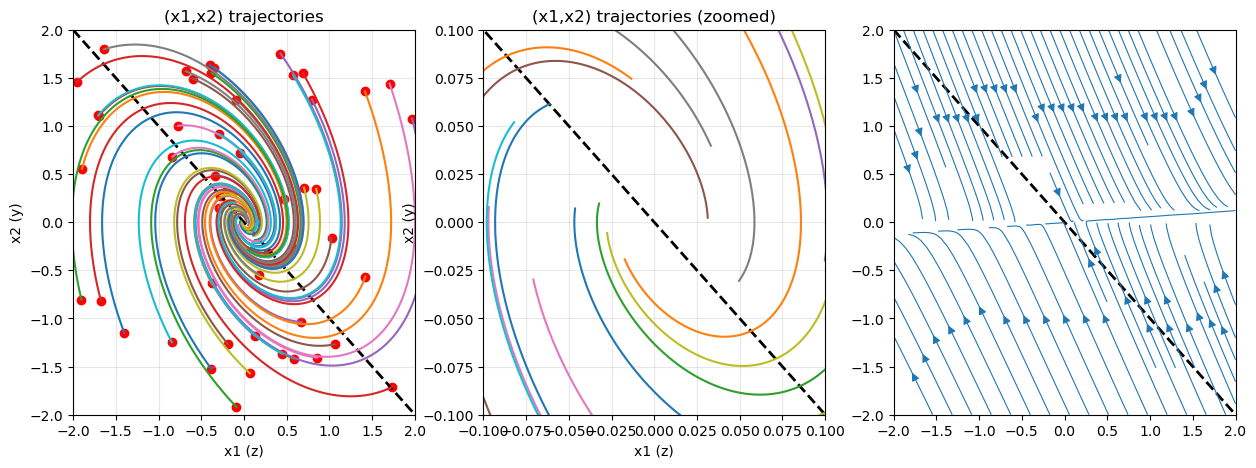

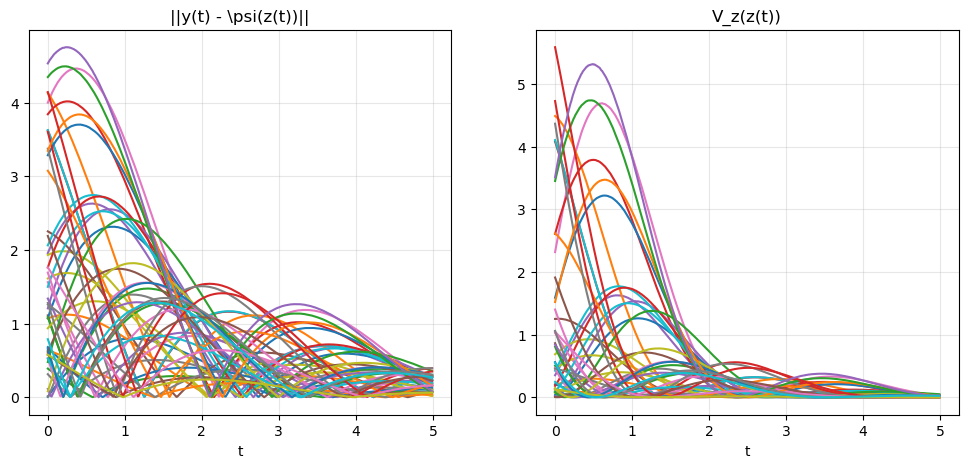

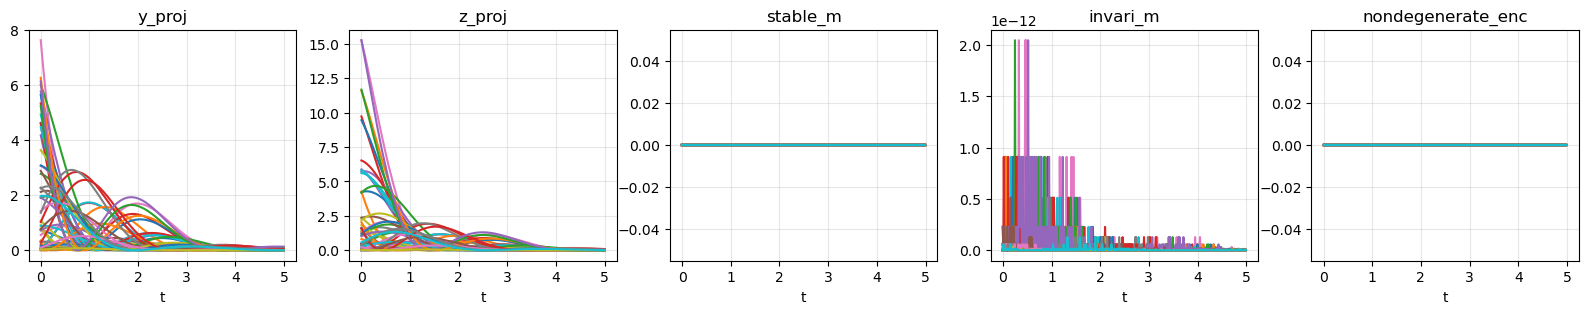

In [2]:

x0s = jax.random.uniform(rng, (50, 2), minval=-cfg_data.box_width, maxval=cfg_data.box_width)

int_out = integrator.apply(x0s, rom=rom)
aux_out = integrator.post_apply(int_out, rom=rom)
loss_out = integrator.compute_loss(int_out, rom=rom)

xs = aux_out.xs

for i in range(xs.shape[0]):
    plt.plot(xs[i, :, 0], xs[i, :, 1])
plt.scatter(xs[:, 0, 0], xs[:, 0, 1], color='red')
plt.show()


make_plots(rom, int_out, aux_out, loss_out)

